In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Reading the Excel file cleaned version of the data

In [3]:
# Load the FAA bird strike data
df_clean= pd.read_csv('data/cleaned_birdstrike_data_V_3.csv')

# Basic inspection
print("Shape of dataset:", df_clean.shape)
df_clean.head()

C:\Users\arsal\AppData\Local\Temp/ipykernel_27596/423349280.py:2: DtypeWarning: Columns (8,9,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean= pd.read_csv('data/cleaned_birdstrike_data_V_3.csv')


Shape of dataset: (324232, 92)


,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,AIRPORT_LATITUDE,AIRPORT_LONGITUDE,...,REMAINS_SENT,WARNED,NUM_SEEN,NUM_STRUCK,SIZE,ENROUTE_STATE,COMMENTS,SOURCE,PERSON,LUPDATE
0,608242,1996-06-22,6,1996,NaN,Unknown,KSMF,SACRAMENTO INTL,38.69542,-121.59077,...,0,Unknown,NaN,1,Medium,NaN,/Legacy Record 100001/,Air Transport Report,Air Transport Operations,2007-12-20
1,608243,1996-06-26,6,1996,NaN,Unknown,KDEN,DENVER INTL AIRPORT,39.85841,-104.667,...,0,Unknown,NaN,1,Medium,NaN,/Legacy Record 100002/,Air Transport Report,Air Transport Operations,2007-12-20
2,608244,1996-07-01,7,1996,NaN,Unknown,KOMA,EPPLEY AIRFIELD,41.30252,-95.89417,...,0,Unknown,NaN,1,Medium,NaN,/Legacy Record 100003/,Air Transport Report,Air Transport Operations,2007-12-20
3,608245,1996-07-01,7,1996,NaN,Unknown,KIAD,WASHINGTON DULLES INTL ARPT,38.94453,-77.45581,...,0,Unknown,NaN,1,Medium,NaN,/Legacy Record 100004/,Air Transport Report,Air Transport Operations,2007-12-20
4,608246,1996-07-01,7,1996,NaN,Unknown,KLGA,LA GUARDIA ARPT,40.77724,-73.87261,...,0,Unknown,NaN,1,Medium,NaN,/Legacy Record 100005/,Air Transport Report,Air Transport Operations,2007-12-20


counts the number of missing (NaN) and non-missing values in the COST_REPAIRS column of df_clean

In [28]:
df_clean["COST_REPAIRS"].isna().sum(), df_clean["COST_REPAIRS"].notna().sum()

(318926, 5306)

creates a new DataFrame df_reg containing only the rows from df_clean where COST_REPAIRS is not missing

In [29]:
df_reg = df_clean[df_clean["COST_REPAIRS"].notna()].copy()


In [31]:
df_reg["COST_REPAIRS"].isna().sum()

0

creates a new column LOG_COST_REPAIRS in df_reg to reduce skewness and stabilize variance in the repair cost data

In [32]:
df_reg["LOG_COST_REPAIRS"] = np.log1p(df_reg["COST_REPAIRS"])


feature correlations with the repair cost target and visualizes the most important ones

📊 Top 15 Correlated Features with COST_REPAIRS:
COST_REPAIRS_INFL_ADJ    0.987325
LOG_COST_REPAIRS         0.358404
COST_OTHER_INFL_ADJ      0.208200
ING_ENG1                 0.199757
COST_OTHER               0.170111
DAM_ENG2                 0.152935
INGESTED_OTHER           0.152437
DAM_ENG1                 0.144129
ENG_1_POS                0.142036
AC_MASS                  0.137029
STR_ENG2                 0.136844
REMAINS_SENT             0.129973
STR_ENG1                 0.120308
ING_ENG2                 0.117521
REMAINS_COLLECTED        0.110514
Name: COST_REPAIRS, dtype: float64

📊 Top 15 Correlated Features with LOG_COST_REPAIRS:
COST_REPAIRS_INFL_ADJ    0.363913
AC_MASS                  0.359076
COST_REPAIRS             0.358404
INGESTED_OTHER           0.352503
NUM_ENGS                 0.310148
DAM_ENG1                 0.296709
ENG_1_POS                0.291138
DAM_ENG2                 0.280700
STR_ENG2                 0.261288
STR_ENG1                 0.258716
REMAINS_SENT  

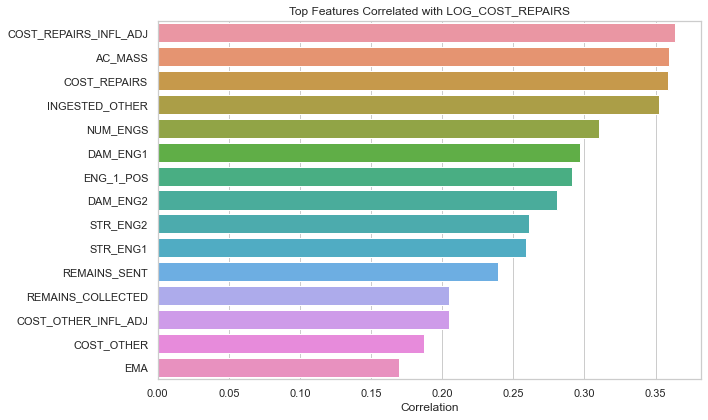

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt




# Select only numeric columns for correlation
numeric_cols = df_reg.select_dtypes(include=[np.number])

# Compute correlations with both raw and log-transformed target
corr_raw = numeric_cols.corr()["COST_REPAIRS"].drop("COST_REPAIRS").sort_values(ascending=False)
corr_log = numeric_cols.corr()["LOG_COST_REPAIRS"].drop("LOG_COST_REPAIRS").sort_values(ascending=False)

# Display top correlated features 
top_corr_raw = corr_raw.abs().sort_values(ascending=False).head(15)
top_corr_log = corr_log.abs().sort_values(ascending=False).head(15)

print("📊 Top 15 Correlated Features with COST_REPAIRS:")
print(top_corr_raw)

print("\n📊 Top 15 Correlated Features with LOG_COST_REPAIRS:")
print(top_corr_log)

# Plot heatmap of correlations with log target
plt.figure(figsize=(10, 6))
sns.barplot(x=top_corr_log.values, y=top_corr_log.index)
plt.title("Top Features Correlated with LOG_COST_REPAIRS")
plt.xlabel("Correlation")
plt.tight_layout()
plt.show()


data inspection for the chosen model features:

selected_features → Defines a list of columns to examine.

Missing values check → Counts null values in each selected feature.

Unique values check → For each feature:

In [34]:
selected_features = [
    "AC_MASS", "NUM_ENGS", "INGESTED_OTHER", "DAM_ENG1", "DAM_ENG2",
    "ENG_1_POS", "STR_ENG2", "STR_ENG1", "REMAINS_SENT", "REMAINS_COLLECTED", "EMA"
]

# Check for missing values
print("🔍 Missing Values:\n")
print(df_reg[selected_features].isnull().sum())
print("\n" + "-"*50)

# Check unique values for categorical or discrete features
for col in selected_features:
    print(f"📌 Feature: {col}")
    unique_vals = df_reg[col].dropna().unique()
    print(f"Unique values ({len(unique_vals)}): {unique_vals[:15]}")
    
    if df_reg[col].dtype in ['int64', 'float64'] and len(unique_vals) > 10:
        print(df_reg[col].describe())
    else:
        print(df_reg[col].value_counts())
    
    print("-" * 50)


🔍 Missing Values:

AC_MASS               40
NUM_ENGS             103
INGESTED_OTHER         0
DAM_ENG1               0
DAM_ENG2               0
ENG_1_POS            102
STR_ENG2               0
STR_ENG1               0
REMAINS_SENT           0
REMAINS_COLLECTED      0
EMA                  326
dtype: int64

--------------------------------------------------
📌 Feature: AC_MASS
Unique values (5): [2. 4. 3. 1. 5.]
AC_MASS
4.0    1704
1.0    1328
2.0    1120
3.0    1031
5.0      83
Name: count, dtype: int64
--------------------------------------------------
📌 Feature: NUM_ENGS
Unique values (4): [2. 1. 3. 4.]
NUM_ENGS
2.0    3474
1.0    1372
3.0     230
4.0     127
Name: count, dtype: int64
--------------------------------------------------
📌 Feature: INGESTED_OTHER
Unique values (2): [0 1]
INGESTED_OTHER
0    4277
1    1029
Name: count, dtype: int64
--------------------------------------------------
📌 Feature: DAM_ENG1
Unique values (2): [0 1]
DAM_ENG1
0    4520
1     786
Name: count, dtyp

encodes the selected features for regression modeling:

Subset relevant data

Keeps only the chosen predictors plus the target variables LOG_COST_REPAIRS and COST_REPAIRS.

Encode categorical EMA

Fills missing values with "Missing".

Converts to strings and encodes them numerically using LabelEncoder.

Fill missing categorical values

For AC_MASS, NUM_ENGS, and ENG_1_POS, fills missing entries with the column’s mode (most frequent value).

Group rare categories in ENG_1_POS

Finds positions that occur fewer than 20 times.

Replaces these rare values with the code 99 to reduce noise and improve model stability.

In [35]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define selected features
selected_features = [
    "AC_MASS",
    "NUM_ENGS",
    "INGESTED_OTHER",
    "DAM_ENG1",
    "DAM_ENG2",
    "ENG_1_POS",
    "STR_ENG2",
    "STR_ENG1",
    "REMAINS_SENT",
    "REMAINS_COLLECTED",
    "EMA"
]

# Subset the dataframe to only relevant features + target
df_reg_cleaned = df_reg[selected_features + ["LOG_COST_REPAIRS", "COST_REPAIRS"]].copy()

# Step 1: Fill missing EMA with 'Missing' label and encode
df_reg_cleaned["EMA"] = df_reg_cleaned["EMA"].fillna("Missing").astype(str)
le = LabelEncoder()
df_reg_cleaned["EMA"] = le.fit_transform(df_reg_cleaned["EMA"])

# Step 2: Fill small missing values for categorical features with mode
for col in ["AC_MASS", "NUM_ENGS", "ENG_1_POS"]:
    df_reg_cleaned[col] = df_reg_cleaned[col].fillna(df_reg_cleaned[col].mode()[0])

# Step 3: Group rare values in ENG_1_POS into '99'
rare_positions = df_reg_cleaned["ENG_1_POS"].value_counts()[df_reg_cleaned["ENG_1_POS"].value_counts() < 20].index
df_reg_cleaned["ENG_1_POS"] = df_reg_cleaned["ENG_1_POS"].apply(lambda x: 99 if x in rare_positions else x)

# Step 4: Final check
print("✅ Missing values in selected features:\n")
print(df_reg_cleaned[selected_features].isnull().sum())


✅ Missing values in selected features:

AC_MASS              0
NUM_ENGS             0
INGESTED_OTHER       0
DAM_ENG1             0
DAM_ENG2             0
ENG_1_POS            0
STR_ENG2             0
STR_ENG1             0
REMAINS_SENT         0
REMAINS_COLLECTED    0
EMA                  0
dtype: int64


splits the cleaned dataset into training and test sets for modeling

In [36]:
from sklearn.model_selection import train_test_split

X = df_reg_cleaned[selected_features]
y = df_reg_cleaned["LOG_COST_REPAIRS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


three regression models for predicting LOG_COST_REPAIRS:

Models Defined

CatBoostRegressor → Gradient boosting model optimized for categorical data.

GradientBoostingRegressor → Scikit-learn’s gradient boosting implementation.

RandomForestRegressor → Ensemble of decision trees for regression tasks.

In [37]:
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define models
models = {
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42)
}

results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    
    print(f"📊 {name} Performance:")
    print(f"  MAE:  ${mae:.2f}")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  R² Score: {r2:.4f}")

# Compare results
print("\n🔍 Summary Comparison:")
for name, scores in results.items():
    print(f"{name}: MAE=${scores['MAE']:.2f}, RMSE=${scores['RMSE']:.2f}, R²={scores['R2']:.4f}")



🔧 Training CatBoost...
📊 CatBoost Performance:
  MAE:  $1.55
  RMSE: $1.97
  R² Score: 0.2574

🔧 Training GradientBoosting...
📊 GradientBoosting Performance:
  MAE:  $1.52
  RMSE: $1.93
  R² Score: 0.2870

🔧 Training RandomForest...
📊 RandomForest Performance:
  MAE:  $1.58
  RMSE: $2.01
  R² Score: 0.2217

🔍 Summary Comparison:
CatBoost: MAE=$1.55, RMSE=$1.97, R²=0.2574
GradientBoosting: MAE=$1.52, RMSE=$1.93, R²=0.2870
RandomForest: MAE=$1.58, RMSE=$2.01, R²=0.2217


In [38]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


evaluates the Gradient Boosting Regressor using 5‑fold cross‑validation:

Model Initialization

Creates a GradientBoostingRegressor with a fixed random_state for reproducibility.

Cross‑Validation

cross_val_score splits the training set into 5 folds.

In each fold, the model is trained on 4 parts and tested on the remaining part.

Uses R² (scoring='r2') as the evaluation metric.

In [39]:
# Initialize the model
gbr = GradientBoostingRegressor(random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(gbr, X_train, y_train, scoring='r2', cv=5)

print(f"📊 Cross-validated R² scores: {cv_scores}")
print(f"📈 Mean R²: {cv_scores.mean():.4f}")


📊 Cross-validated R² scores: [0.34117622 0.27463206 0.34436329 0.2487179  0.29792919]
📈 Mean R²: 0.3014


repair cost prediction for a new incident example

In [42]:
import numpy as np

# Example new input 
new_data = {
    "AC_MASS": 4,
    "NUM_ENGS": 2,
    "INGESTED_OTHER": 1,
    "DAM_ENG1": 1,
    "DAM_ENG2": 0,
    "ENG_1_POS": 1,
    "STR_ENG2": 0,
    "STR_ENG1": 1,
    "REMAINS_SENT": 1,
    "REMAINS_COLLECTED": 1,
    "EMA": 20
}

# Convert to DataFrame for prediction
import pandas as pd
input_df = pd.DataFrame([new_data])

# Predict log value
predicted_log = best_gbr.predict(input_df)[0]

# Convert back to dollar value
predicted_cost = np.expm1(predicted_log)
print(f"💵 Predicted Repair Cost: ${predicted_cost:.2f}")


💵 Predicted Repair Cost: $96359.94


saving the model

In [43]:
import joblib

joblib.dump(best_gbr, "gbr_repair_cost_model.pkl")
print("✅ Model saved as 'gbr_repair_cost_model.pkl'")


✅ Model saved as 'gbr_repair_cost_model.pkl'


In [44]:
loaded_model = joblib.load("gbr_repair_cost_model.pkl")


In [45]:
log_pred = loaded_model.predict(input_df)[0]
actual_cost = np.expm1(log_pred)
print(f"💸 Predicted Cost: ${actual_cost:.2f}")


💸 Predicted Cost: $96359.94


Integrating tabular data into RAG (Retrieval-Augmented Generation) pipelines

In [4]:
from langchain_community.document_loaders.dataframe import DataFrameLoader


FAA bird strike incident data for use in a LangChain-based RAG pipeline by:

Formatting each record as readable text

format_incident(row) builds a structured incident report string with icons and clear labels.

Handles missing or unrealistic COST_REPAIRS values by replacing them with "N/A".

Applying the formatter

Adds a new "text" column to docs_df, where each row contains the formatted report text.

Loading into LangChain

Uses DataFrameLoader to turn each "text" entry into a LangChain Document object for retrieval or summarization.

Splitting into chunks

Uses RecursiveCharacterTextSplitter to break long documents into smaller chunks (500 characters, with 50 characters overlap) for better embedding and search performance.

In [5]:
import numpy as np

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Format DataFrame into text
def format_incident(row):
    # Handle NaN or huge repair cost safely
    try:
        if not np.isnan(row['COST_REPAIRS']) and row['COST_REPAIRS'] < 1e10:
            repair_cost = f"${row['COST_REPAIRS']:,.2f}"
        else:
            repair_cost = "N/A"
    except:
        repair_cost = "N/A"

    return f"""
🛩️ Aircraft Incident Report
- 📅 Date: {row['INCIDENT_DATE']} (Month: {row['INCIDENT_MONTH']}, Year: {row['INCIDENT_YEAR']})
- 🕑 Time of Day: {row['TIME_OF_DAY']}
- 🛫 Airport: {row['AIRPORT']} (ID: {row['AIRPORT_ID']}, State: {row['STATE']}, Region: {row['FAAREGION']})
- ✈️ Aircraft: {row['AIRCRAFT']} | Operator: {row['OPERATOR']}
- ⚙️ Engines: {row['NUM_ENGS']} (Type: {row['TYPE_ENG']}, Position: ENG1: {row['ENG_1_POS']}, ENG2: {row['ENG_2_POS']})
- 🚀 Phase of Flight: {row['PHASE_OF_FLIGHT']} | Altitude: {row['HEIGHT']} ft | Speed: {row['SPEED']} kts
- ☁️ Weather: Sky: {row['SKY']}, Precipitation: {row['PRECIPITATION']}
- 💥 Strike: ENG1 Struck: {row['STR_ENG1']}, Damaged: {row['DAM_ENG1']} | ENG2 Struck: {row['STR_ENG2']}, Damaged: {row['DAM_ENG2']}
- 🦅 Bird Species: {row['SPECIES']} (Size: {row['SIZE']}, Number Seen: {row['NUM_SEEN']}, Struck: {row['NUM_STRUCK']})
- 💸 Repair Cost: {repair_cost}
- 📝 Remarks: {row['REMARKS']}
""".strip()


# Apply formatting
docs_df = df_clean.copy()
docs_df["text"] = docs_df.apply(format_incident, axis=1)

# Load into LangChain
loader = DataFrameLoader(docs_df[["text"]], page_content_column="text")
docs = loader.load()

# Split long documents
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)


In [6]:
key="...."

In [7]:
import os
os.environ["OPENAI_API_KEY"] = key  


In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


Connects to OpenAI’s API to generate vector embeddings for text.

These embeddings are high‑dimensional numeric representations of text meaning.

They are typically used in semantic search, clustering, and RAG pipelines to compare document similarity.

In [9]:
from langchain_openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings()


Store and index text embeddings for fast similarity search

In [10]:
from langchain.vectorstores import FAISS

In [22]:
# Use only the first 10 chunks
sample_chunks = chunks[:10000]


Create the FAISS index and Saves the FAISS index and metadata to the "faiss_openai_index" 

In [23]:





vectorstore = FAISS.from_documents(sample_chunks, embedding)

# 3. Save it for reuse
vectorstore.save_local("faiss_openai_index")
